# Performance Bencharmk: Accessing Datasets in the Jasmin Object Store

In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import chain

from performance_plots import plot_barplot, plot_lineplot
from performance_utils import calculate_speed_up

In [2]:
# Warning settings
warnings.filterwarnings("ignore")

# Seaborn settings
sns.set()
sns.set_style("white")
sns.set_context("notebook", font_scale=0.95)

# Matplotlib settings
plt.rcParams.update({"xtick.bottom": True, "ytick.left": True})

In [3]:
output_file_prefix = "performance_annual_mean_optimal"
save_fig = False
error_kwargs = {"capsize": 0.1, "errwidth": 1, "errorbar": "sd"}

## Annual mean of the depth profile at a grid point // Annual mean of the surface layer

In [4]:
# Open the csv files
# Annual mean of the deapth profile at a grid point
df_grid_orig = pd.read_csv(
    "benchmark_data/raw_data/performance_annual_mean_depth_profile_grid.csv"
)
df_grid_opt = pd.read_csv(
    "benchmark_data/raw_data/performance_annual_mean_depth_profile_grid_optimal.csv"
)
df_grid_opt.drop(df_grid_opt[df_grid_opt["Replicate"] == 0].index, inplace=True)
df_grid = pd.concat([df_grid_orig, df_grid_opt])
df_grid.drop(df_grid.filter(regex="Unname"), axis=1, inplace=True)

# Annual mean of the surface layer
df_surf_orig = pd.read_csv(
    "benchmark_data/raw_data/performance_annual_mean_surface_layer.csv"
)
df_surf_opt = pd.read_csv(
    "benchmark_data/raw_data/performance_annual_mean_surface_layer_optimal.csv"
)
df_surf_opt.drop(df_surf_opt[df_surf_opt["Replicate"] == 0].index, inplace=True)
df_surf = pd.concat([df_surf_opt, df_surf_orig])
df_surf.drop(df_surf.filter(regex="Unname"), axis=1, inplace=True)
df_surf.head()

,Replicate,Configuration,Walltime,Label,Dataset
1,1.0,1:1:1,241.761930,multithreading,zarr-part-month-2
2,2.0,1:1:1,309.500563,multithreading,zarr-part-month-2
3,3.0,1:1:1,289.928426,multithreading,zarr-part-month-2
4,4.0,1:1:1,270.502426,multithreading,zarr-part-month-2
6,1.0,2:1:2,133.335107,multithreading,zarr-part-month-2


### Optimal chunk size for annual means

In [5]:
# Define the chunksize for each dataset
chunksize = {
    "zarr-part-month-orig": 1.98,
    "zarr-part-month": 6.35,
    # "zarr-part-month-2": 2.11,
    "zarr-part-month-3": 28.03,
    "zarr-part-month-4": 63.06,
    "zarr-part-month-5": 112.14,
    "zarr-part-depth-month": 252.17,
}

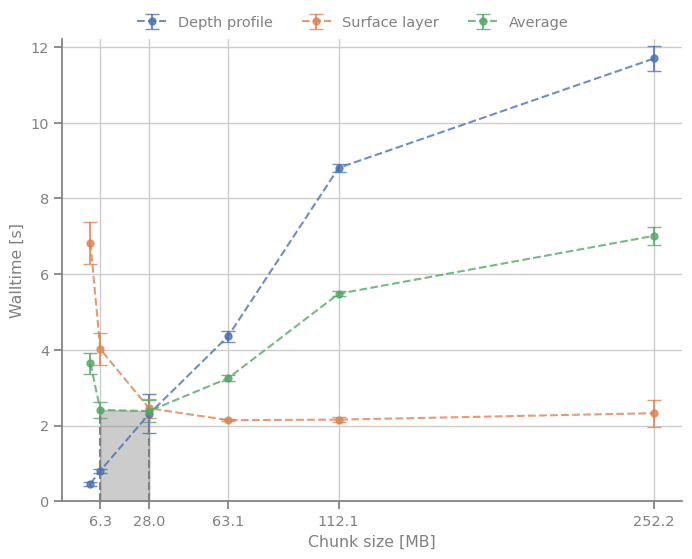

In [6]:
config = "16:8:2"
datasets = list(chunksize.keys())
colors = (c for c in sns.color_palette("deep"))

# Walltime means
means_grid = [
    df_grid.loc[
        (df_grid["Configuration"] == config) & (df_grid["Dataset"] == dataset)
    ].mean()["Walltime"]
    for dataset in datasets
]
means_surf = [
    df_surf.loc[
        (df_surf["Configuration"] == config) & (df_surf["Dataset"] == dataset)
    ].mean()["Walltime"]
    for dataset in datasets
]
means_both = [(x + y) / 2.0 for x, y in zip(means_grid, means_surf)]

# Standard deviations
stddev_grid = [
    df_grid.loc[
        (df_grid["Configuration"] == config) & (df_grid["Dataset"] == dataset)
    ].std()["Walltime"]
    for dataset in datasets
]
stddev_surf = [
    df_surf.loc[
        (df_surf["Configuration"] == config) & (df_surf["Dataset"] == dataset)
    ].std()["Walltime"]
    for dataset in datasets
]
stddev_both = [np.sqrt(x * x + y * y) / 2.0 for x, y in zip(stddev_grid, stddev_surf)]

sizes = list(chunksize.values())


f, ax = plt.subplots(figsize=(8, 6))
error_kwargs = {
    "err_kws": {"lw": 1, "capsize": 5},
    "err_style": "bars",
    "errorbar": "sd",
}

for y, std, label in zip(
    [means_grid, means_surf, means_both],
    [stddev_grid, stddev_surf, stddev_both],
    ["Depth profile", "Surface layer", "Average"],
):
    ax.errorbar(
        sizes,
        y,
        std,
        color=next(colors),
        lw=1.5,
        alpha=0.8,
        linestyle="dashed",
        marker="o",
        markersize=5,
        label=label,
        capsize=5,
        capthick=1,
    )

# Grid, lims
ax.grid(visible=True, which="major", axis="both")
ax.set_ylim([0, 12.2])

# Label
ax.set_xlabel("Chunk size [MB]")
ax.set_ylabel("Walltime [s]")
ax.xaxis.label.set_color("grey")
ax.yaxis.label.set_color("grey")

# Spines' visibility
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(True)
ax.spines["left"].set_visible(True)

# Spines' color
ax.spines["top"].set_color("grey")
ax.spines["right"].set_color("grey")
ax.spines["bottom"].set_color("grey")
ax.spines["left"].set_color("grey")

# Ticks
ax.tick_params(colors="grey", which="both")

# Legend
leg = ax.legend(
    frameon=False,
    labelcolor="grey",
    bbox_to_anchor=(0.1, 1.08),
    title="",
    ncol=3,
    loc="upper left",
)
plt.setp(leg.get_title(), color="grey")
# Vertical lines
ax.vlines(x=sizes[1], ymin=0, ymax=means_both[1], colors="grey", linestyles="--")
ax.vlines(x=sizes[2], ymin=0, ymax=means_both[2], colors="grey", linestyles="--")
ax.fill_between(sizes[1:3], means_both[1:3], alpha=0.4, color="grey")
ax.set_xticks(sizes[1:])

if save_fig:
    plt.savefig(
        f"{output_file_prefix}_optimal_chunksize.png",
        dpi=600,
        transparent=True,
        bbox_inches="tight",
    )
plt.show()

- The optimal chunksize is somewhere between ca. 5-30 MB.
- As a rule of thumb, chunks of approximately 10 MB should perform well.